Data gathering

analysis of 2 or 3 different kind of algorithms we will use: kNN, maxent, logistic regression, deep learning, and support vector machines.

each method has a different pre processing and strengths and interpretatio


kNN- tokenizing, all lower case, removing common words, lematisize, tagging words as preposition/conjunction/etc,  TF IDF

Do we remove stop words, or not?
Do we stem or lemmatize our text data, or leave the words as is?
Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
Do we stick with English words only or do we allow for other languages?
Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?

In [245]:
#!pip install Levenshtein
#!pip install pandas
#!pip install nltk
#!pip install Levenshtein
#!pip install textblob
#!pip install scikit-learn

In [379]:
#imports

import numpy as np
from textblob import TextBlob
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import re
import os
import nltk
import Levenshtein
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline
import plotly.express as px
from collections import Counter

In [247]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [248]:
import shutil

def zip_folder(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

# Example usage
#folder_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT/Raw_Songs_DataBase'  # Replace with the path to your folder
#zip_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT'  # Replace with the desired path and name for the zip file

#zip_folder(folder_path, zip_path)

In [249]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [250]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 70

In [251]:
#get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
artists = random.sample(artists_all, NUMBER_OF_ARTISTS)
artists = sorted(artists)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    
    print(art)
    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    #path_to_rid = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

Adele
Andrew Bird
Average White Band
Avicii
Barry White
Between the Buried and Me
Billie Eilish
Brandi Carlile
Built to Spill
Charlie Puth
Chic
Chris Stapleton
Cocteau Twins
Commodores
Daft Punk
Deadmau5
Deerhunter
Doja Cat
Donna Summer
Dream Theater
Etta James
Fontaines D.C
Gang of Four
Gap Band
Gaynor
Hank Williams
Isley Brothers
J. Cole
JPEGMAFIA
Jackson
Japanese Breakfast
Jason Isbell
Judy Collins
Kacey Musgraves
KanyeWest
Kero Kero Bonito
Kraftwerk
Lady Gaga
Lizzo
Loretta Lynn
Mastodon
Mick Jenkins
Nanci Griffith
Neko Case
Nick Drake
Noname
Orville Peck
Prince
Queen
Radiohead
Reba McEntire
Rick James
Robyn
Sister Sledge
Slayer
Sly & The Family Stone
Steve Earle
Sturgill Simpson
Sufjan Stevens
Supremes
Tavares
Temptations
Tierra Whack
Trammps
Troye Sivan
Vampire Weekend
Vandross
Village People
pantera
slipknot


In [252]:
#print(len(artists))

In [253]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()


Now let us get some data about the songs

Number of songs : 5727
Number of artists : 70
Average number of songs per artist : 81


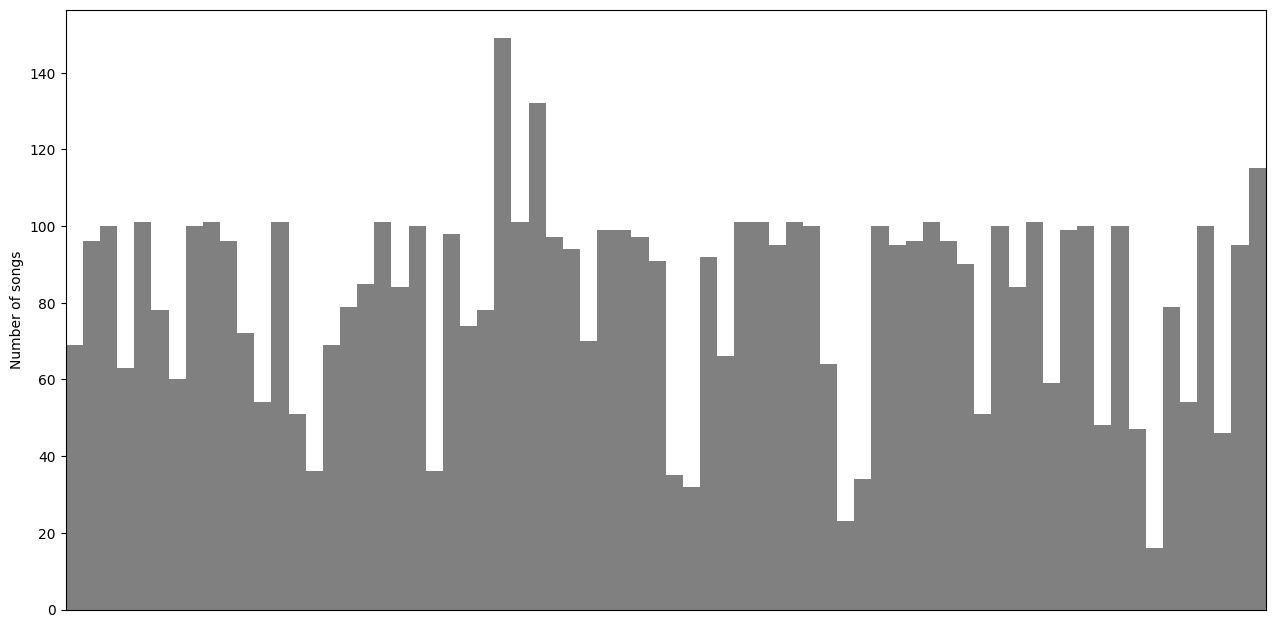

In [254]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

keys = songs_per_artist.keys()
values = songs_per_artist.values()

fig = plt.figure(figsize=(12, 6))  # Set the figure size
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust margins

bar_lefts = range(len(keys))
bar_heights = values

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')  # Customize the appearance

plt.ylabel('Number of songs')

plt.xticks([])  # Remove x-axis tick labels
plt.xlabel('')  # Remove x-axis legend

plt.xlim(-0.5, len(keys) - 0.5)  # Adjust x-axis limits

plt.show()

In [255]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #get number of lines
    nb_lines = text.count("\n")
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists
    text = [word for sentence in text for word in sentence]
    
    #remove all expressions in between brackets and empty words
    text = [word for word in text if len(word) != 0 and word[0]!= "["]
    
    #stemmatization
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    
    nb_words = len(text)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

Let's vizualize the data

In [256]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [257]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist
0,"[i, will, leav, my, heart, at, the, door, i, w...",49,286,\nI will leave my heart at the door\nI won't s...,all i ask,0
1,"[i, know, you'v, got, thing, to, do, i, do, to...",30,168,\nI know you've got things to do (I do too)\nI...,all night parking,0
2,"[sha, la, la, la, la, la, la, la, sha, la, la,...",47,236,\nSha la la la la la la la\nSha la la la la la...,baby it's you,0
3,"[wait, do, you, see, my, heart, on, my, sleev,...",52,410,"\nWait, do you see my heart on my sleeve?\nIt'...",best for last,0
4,"[if, fish, swam, out, of, the, ocean, and, gre...",59,318,\nIf fish swam out of the ocean\nAnd grew legs...,black & gold,0


In [258]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(range(len(artists)), 10)
else:
    sample = random.sample(range(len(artists)), NUMBER_OF_ARTISTS)

In [259]:
def plot_box_graph(features):
    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [artists[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])
                


        xtick_labels = [artists[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        
        plt.show()
        
def plot_bar_graph(feature):
    
    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

    plt.bar(np.arange(len(to_plot)), to_plot) 
    xtick_labels = [artists[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)  
    plt.title(feature)

    plt.show()

In [260]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [261]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,...,RID_PRIMARY:ICARIAN:IMAGERY:FIRE,RID_PRIMARY:SENSATION:ODOR,RID_SECONDARY:ORDER,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:DIFFUSION,RID_EMOTIONS:SADNESS,RID_PRIMARY:REGRESSIVE:COGNITION:UNKNOWN,RID_PRIMARY:NEED:ANALITY,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[i, will, leav, my, heart, at, the, door, i, w...",49,286,\nI will leave my heart at the door\nI won't s...,all i ask,0,0.049834,0.029900,0.029900,0.023256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.666667,51.666667,31.666667
1,"[i, know, you'v, got, thing, to, do, i, do, to...",30,168,\nI know you've got things to do (I do too)\nI...,all night parking,0,0.005525,0.005525,0.022099,0.033149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000,36.842105,13.157895
2,"[sha, la, la, la, la, la, la, la, sha, la, la,...",47,236,\nSha la la la la la la la\nSha la la la la la...,baby it's you,0,0.003968,0.019841,0.023810,0.011905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.142857,53.571429,14.285714
3,"[wait, do, you, see, my, heart, on, my, sleev,...",52,410,"\nWait, do you see my heart on my sleeve?\nIt'...",best for last,0,0.013514,0.018018,0.027027,0.013514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.506849,57.534247,10.958904
4,"[if, fish, swam, out, of, the, ocean, and, gre...",59,318,\nIf fish swam out of the ocean\nAnd grew legs...,black & gold,0,0.000000,0.002933,0.032258,0.035191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.101266,30.379747,21.518987


In [262]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 84 duplicates


In [263]:
def similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / max_length * 100
    return similarity

# Create a mask to identify the rows to drop
mask = np.zeros(len(df), dtype=bool)

for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # Filter rows with the same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    
    # Calculate similarity scores between song1 and duplicate rows
    similarity_scores = duplicate_rows["Raw_Lyrics"].apply(lambda x: similarity(song1, x))
    
    # Identify rows with similarity scores above 80
    similar_rows = duplicate_rows[similarity_scores > 80]
    
    #if duplicate_rows.shape[0] != 0:
        #print(f'duplicates : {duplicate_rows.shape[0]}')
        #print(f'sim : {similar_rows.shape[0]}')
    #for _, row in similar_rows.iterrows():
        #title1 = row["Title"]
        #artist1 = row["Artist"]
        #print(f'{title1} from {artists[artist1]}')
    
    
    # Mark the indices to be dropped in the mask
    #mask[idx1] = True
    df.drop(similar_rows.index, inplace=True)

# Drop the marked rows using the mask
#df.drop(df.index[mask], inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 19 covers


In [264]:
df = df[df['Nb_Words'] >= 50]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s5 = df.shape[0]

print(f'Dropped {s4 - s5} intros and outros')

Dropped 152 songs that were too short
Dropped 6 intros and outros


In [265]:
# Compute the count of instances for each artist
artist_counts = df['Artist'].value_counts()

# Identify artists with counts less than 50
artists_to_drop = artist_counts[artist_counts < 50].index

# Create a boolean mask indicating rows to be dropped
mask = df['Artist'].isin(artists_to_drop)

# Filter and drop the corresponding rows from the DataFrame
#df.drop(df[mask].index, inplace=True)

l1 = len(artists)
# Remove the artists from the artists array
#artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
l2 = len(artists)

s6 = df.shape[0]
print(f'Dropped {l1 - l2} artists that had too few songs : -{s5 - s6} songs')

Dropped 0 artists that had too few songs : -0 songs


In [266]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Hank Williams (149 songs)
Artist with the least songs: Kraftwerk (9 songs)


In [267]:
# Identify artists with a total number of songs greater than 130
artists_above_threshold = artist_counts[artist_counts > 130].index

# Iterate over each artist
for artist in artists_above_threshold:
    # Get the indices of songs by the current artist
    artist_indices = df[df['Artist'] == artist].index
    
    # Calculate the number of songs to be dropped
    songs_to_drop = len(artist_indices) - 130
    
    # Randomly select and drop songs until count reaches 130
    songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
    #df.drop(artist_indices.difference(songs_to_keep), inplace=True)

s7 = df.shape[0]
print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

Dropped 0 songs from undersampling too represented artists


In [268]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(artists))}')

AFTER CLEANING

Number of songs : 5466
Number of artists : 70
Average number of songs per artist : 78


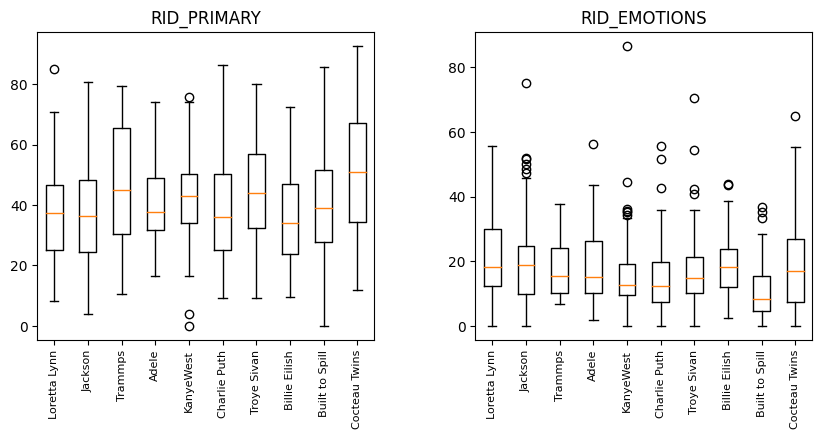

In [269]:
plot_box_graph(["RID_PRIMARY", "RID_EMOTIONS"])

In [270]:
df_rid = df.filter(regex=r'^RID')
df_rid

,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:ANXIETY,RID_PRIMARY:SENSATION:VISION,RID_PRIMARY:SENSATION:SOUND,RID_PRIMARY:REGRESSIVE:COGNITION:CONCRETENESS,...,RID_PRIMARY:ICARIAN:IMAGERY:FIRE,RID_PRIMARY:SENSATION:ODOR,RID_SECONDARY:ORDER,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:DIFFUSION,RID_EMOTIONS:SADNESS,RID_PRIMARY:REGRESSIVE:COGNITION:UNKNOWN,RID_PRIMARY:NEED:ANALITY,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,0.049834,0.029900,0.029900,0.023256,0.016611,0.016611,0.006645,0.006645,0.003322,0.003322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.666667,51.666667,31.666667
1,0.005525,0.005525,0.022099,0.033149,0.016575,0.000000,0.005525,0.005525,0.000000,0.044199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,36.842105,13.157895
2,0.003968,0.019841,0.023810,0.011905,0.000000,0.000000,0.000000,0.000000,0.007937,0.019841,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.142857,53.571429,14.285714
3,0.013514,0.018018,0.027027,0.013514,0.022523,0.000000,0.000000,0.002252,0.013514,0.018018,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.506849,57.534247,10.958904
4,0.000000,0.002933,0.032258,0.035191,0.000000,0.005865,0.008798,0.032258,0.000000,0.029326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.101266,30.379747,21.518987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,0.007692,0.017949,0.012821,0.005128,0.002564,0.017949,0.000000,0.028205,0.002564,0.066667,...,0.000000,0.002564,0.000000,0.000000,0.005128,0.000000,0.000000,69.696970,16.161616,14.141414
5723,0.007958,0.013263,0.023873,0.026525,0.010610,0.002653,0.000000,0.000000,0.000000,0.018568,...,0.000000,0.000000,0.002653,0.002653,0.000000,0.002653,0.000000,37.500000,45.833333,16.666667
5724,0.000000,0.011876,0.033254,0.038005,0.011876,0.002375,0.002375,0.000000,0.000000,0.009501,...,0.007126,0.000000,0.000000,0.000000,0.002375,0.000000,0.000000,27.397260,61.643836,10.958904
5725,0.015625,0.007812,0.000000,0.007812,0.000000,0.007812,0.000000,0.007812,0.015625,0.023438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,63.157895,21.052632,15.789474


In [271]:
# Instantiate PCA with the number of components set to the total number of features
pca = PCA(n_components=len(df_rid.columns))

# Fit PCA on the standardized features
pca.fit(df_rid)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the variance ratios in descending order
sorted_variance_ratio = sorted(explained_variance_ratio, reverse=True)

# Get the indices of the top 10 features with the most variance
top_10_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Keep only the top 10 features in the DataFrame
df_top_10 = df_rid.iloc[:, top_10_indices]
df_top_10.columns

Index(['RID_EMOTIONS:AFFECTION', 'RID_SECONDARY:SOCIAL:BEHAVIOR',
       'RID_SECONDARY:ABSTRACTION', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       'RID_SECONDARY:INSTRUMENTAL:BEHAVIOR',
       'RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM', 'RID_EMOTIONS:ANXIETY',
       'RID_PRIMARY:SENSATION:VISION', 'RID_PRIMARY:SENSATION:SOUND',
       'RID_PRIMARY:REGRESSIVE:COGNITION:CONCRETENESS'],
      dtype='object')

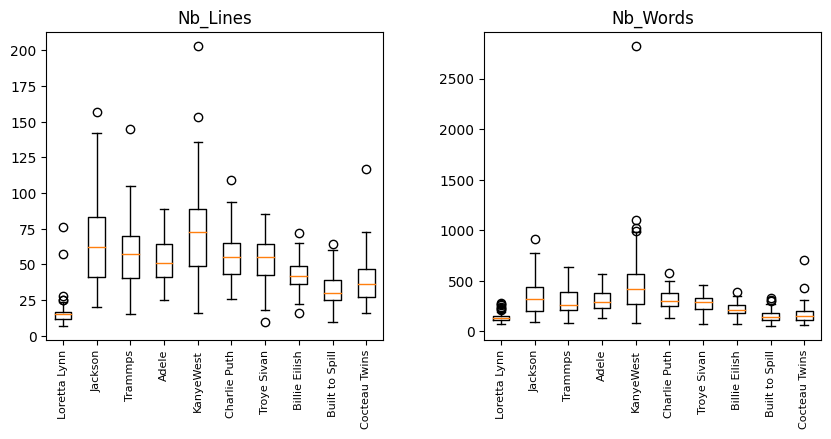

In [272]:
plot_box_graph(["Nb_Lines", "Nb_Words"])

In [273]:
df["Nb_Words_Per_Line"] = df["Nb_Words"]/df["Nb_Lines"]

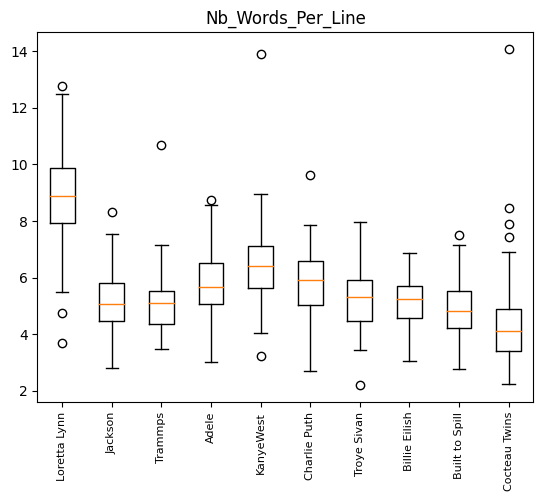

In [274]:
plot_box_graph(["Nb_Words_Per_Line"])

We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [275]:
songs = df["Lyrics"].to_list()
nb_words = df["Nb_Words"].to_list()

#unique word means appears only once in the song
TTR = []
for song, l in zip(songs, nb_words):
    dic = {word: 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word] += 1
        if dic[word] > 1: #if it appeared more than once, add it
            non_unique_words.add(word)
    nb_unique_words = l - len(non_unique_words)
    ttr = nb_unique_words / l
    TTR.append(ttr)
    
df['TTR'] = TTR

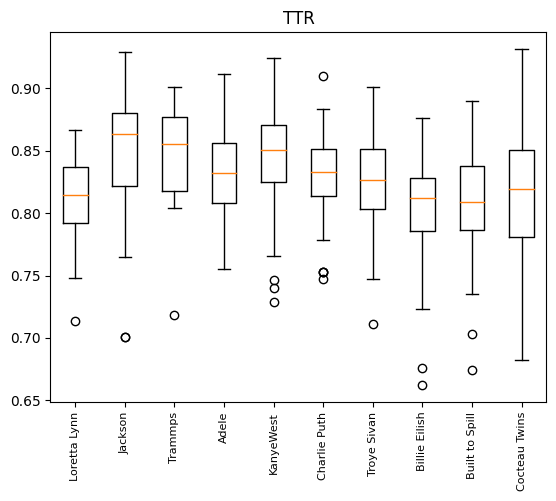

In [276]:
plot_box_graph(["TTR"])

In [277]:
supertags_dict = {
    'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V', #verbs
    'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N', #nouns
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', #adverbs
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ', #adjectives
    'DT': 'DET', 'PDT': 'DET', 'WDT': 'DET', #determinents
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON'} #pronouns

supertags = ['N', 'V', 'ADV', 'ADJ', 'DET', 'PRON']
chunk_tags = ['GPE', 'PERSON', 'ORGANIZATION', 'LOCATION', 'FACILITY', 'GSP']

#'GPE': 'Geopolitical Entity: Refers to countries, cities, states, or regions.',
#'PERSON': 'Person: Refers to individuals or groups of people.',
#'ORGANIZATION': 'Organization: Refers to named entities representing companies, institutions, or groups.',
#'LOCATION': 'Location: Refers to specific places or locations.',
#'FACILITY': 'Facility: Refers to buildings, structures, or other physical facilities.',
#'GSP': 'General Single Purpose: Refers to a general chunk tag with a single-purpose label.'

def split_sentences(text):

    text = re.sub(r'\([^()]*\)', ' ', text)
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('  ', ' ')
    sentences = re.split(r'(?:[.!?])|\n\n', text)
    sentences = [s.strip() for s in sentences if len(s)!=0]
    return sentences

In [278]:
def pos_chunk(text):
    # Tokenize into sentences and words
    sentences = split_sentences(text)
    words = [nltk.word_tokenize(sent) for sent in sentences]
    
    # POS tagging
    pos_tags = [nltk.pos_tag(sent) for sent in words]
    
    # Chunking
    chunked_sentences = [nltk.ne_chunk(pos_tag_sent) for pos_tag_sent in pos_tags]

    # Calculate POS tag distribution
    pos_tag_distribution = {suptag: 0 for suptag in supertags}
    for sent in pos_tags:
        pos_tag_distribution.update({supertags_dict[tag]: pos_tag_distribution.get(supertags_dict[tag], 0) + 1
                                     for _, tag in sent if tag in supertags_dict})

    # Calculate chunk tag distribution
    chunk_tag_distribution = {chunk_tag: 0 for chunk_tag in chunk_tags}
    for sent in chunked_sentences:
        chunk_tag_distribution.update({chunk.label(): chunk_tag_distribution.get(chunk.label(), 0) + 1
                                       for chunk in sent if hasattr(chunk, 'label') and chunk.label() in chunk_tags})

    return pos_tag_distribution, chunk_tag_distribution


In [279]:
raw_songs = df["Raw_Lyrics"].to_list()
#df = df.drop("Raw_Lyrics", axis = 1)
nb_words = df["Nb_Words"].to_list()

In [280]:

POS = {'POS_'+key : [] for key in supertags}

CHUNK = {'CHUNK_'+key : [] for key in chunk_tags}

for raw, l in zip(raw_songs, nb_words):
    print(len(POS["POS_N"]))
    pos, chunk = pos_chunk(raw)
    for key in pos.keys():
        POS['POS_'+key].append(pos[key] / l)
        
    for key in chunk.keys():
        CHUNK['CHUNK_'+key].append(chunk[key] / l)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [281]:
df = df.assign(**POS)
df = df.assign(**CHUNK)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,...,POS_ADV,POS_ADJ,POS_DET,POS_PRON,CHUNK_GPE,CHUNK_PERSON,CHUNK_ORGANIZATION,CHUNK_LOCATION,CHUNK_FACILITY,CHUNK_GSP
0,"[i, will, leav, my, heart, at, the, door, i, w...",49,286,\nI will leave my heart at the door\nI won't s...,all i ask,0,0.049834,0.029900,0.029900,0.023256,...,0.027972,0.027972,0.027972,0.027972,0.006993,0.000000,0.003497,0.0,0.0,0.0
1,"[i, know, you'v, got, thing, to, do, i, do, to...",30,168,\nI know you've got things to do (I do too)\nI...,all night parking,0,0.005525,0.005525,0.022099,0.033149,...,0.023810,0.017857,0.023810,0.017857,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,"[sha, la, la, la, la, la, la, la, sha, la, la,...",47,236,\nSha la la la la la la la\nSha la la la la la...,baby it's you,0,0.003968,0.019841,0.023810,0.011905,...,0.021186,0.016949,0.008475,0.021186,0.000000,0.004237,0.000000,0.0,0.0,0.0
3,"[wait, do, you, see, my, heart, on, my, sleev,...",52,410,"\nWait, do you see my heart on my sleeve?\nIt'...",best for last,0,0.013514,0.018018,0.027027,0.013514,...,0.024390,0.014634,0.021951,0.026829,0.004878,0.000000,0.000000,0.0,0.0,0.0
4,"[if, fish, swam, out, of, the, ocean, and, gre...",59,318,\nIf fish swam out of the ocean\nAnd grew legs...,black & gold,0,0.000000,0.002933,0.032258,0.035191,...,0.018868,0.022013,0.015723,0.018868,0.000000,0.012579,0.000000,0.0,0.0,0.0


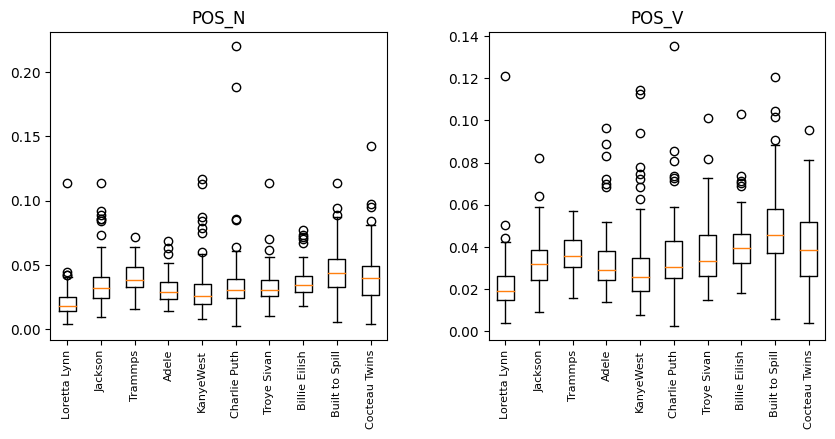

In [282]:
plot_box_graph(["POS_N", "POS_V"])

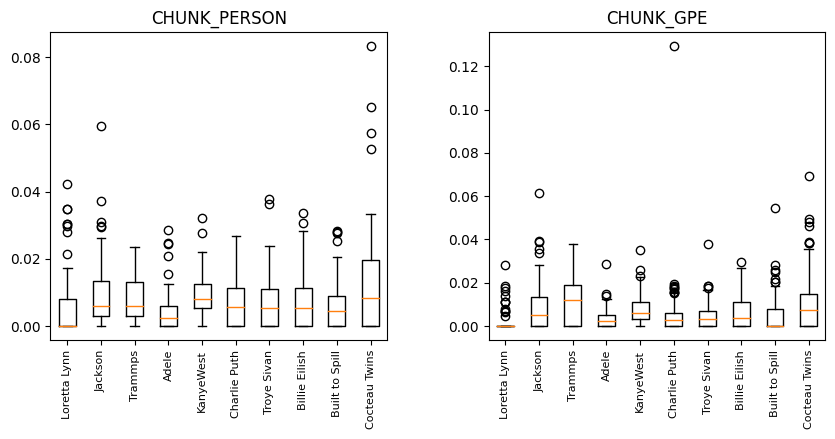

In [283]:
plot_box_graph(["CHUNK_PERSON", "CHUNK_GPE"])

Now we analyze prononces. We count the frequencies of 1st, 2nd, 3rd person pronons and the ratio of 1st person to 2d person to detect dialogue and interpersonal relations.

In [284]:
path_to_dicts = os.path.join(os.getcwd(), "Dictionaries")

path = os.path.join(path_to_dicts, "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(path_to_dicts, "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

songs = df["Lyrics"].to_list()

for song in songs:

    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

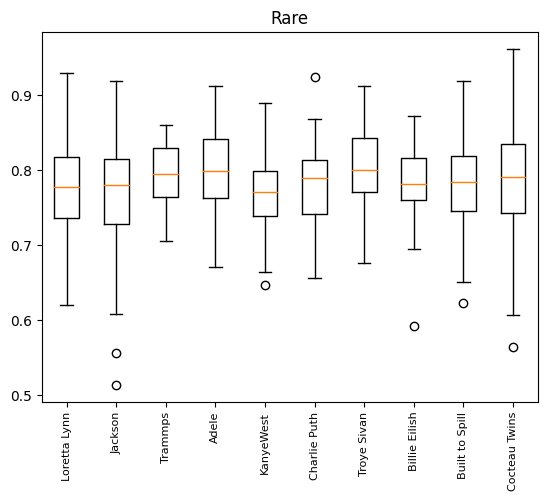

In [285]:
plot_box_graph(["Rare"])

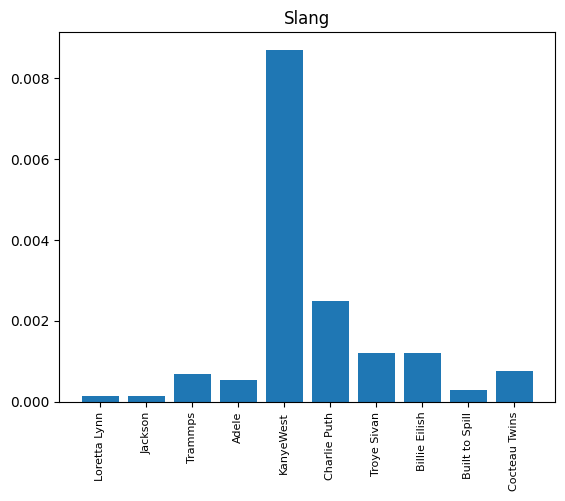

In [286]:
plot_bar_graph("Slang")

In [287]:
first_pers = []
second_pers = []
third_pers = []

for song in songs:
    first_pers_count = 0
    second_pers_count = 0
    third_pers_count = 0

    for word in song:
        if word in  {"i", "we"}:
            first_pers_count += 1
        if word == "you":
            second_pers_count += 1
        if word in  {"he", "she", "they"}:
            third_pers_count += 1
    
    song_len = len(song)
    first_pers.append(first_pers_count/song_len)
    second_pers.append(second_pers_count/song_len)
    third_pers.append(third_pers_count/song_len)
    
df['FP_Freq'] = first_pers
df['SP_Freq'] = second_pers
df['TP_Freq'] = third_pers

df["SR"] = df['FP_Freq']/(1 + df['SP_Freq'] + df['TP_Freq'])

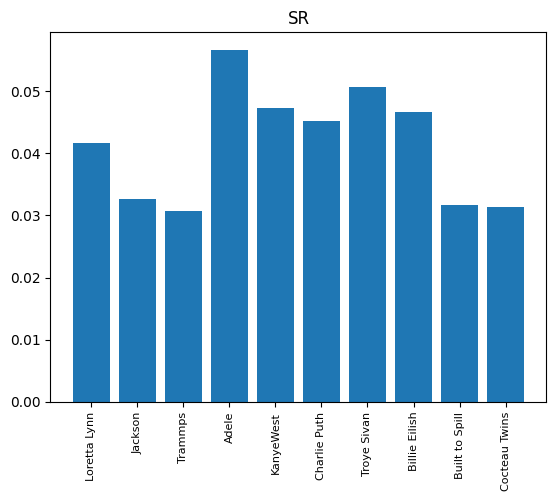

In [288]:
plot_bar_graph("SR")

Now we check whether or not the title appears in the song.

In [289]:
ttls = df["Title"].to_list()

title_in_song = []

raw_songs = [s.lower() for s in raw_songs]


for song, title, art in zip(raw_songs, ttls, df["Artist"].to_list()):
    pattern = re.escape(title)  # Escape special characters in the title
    if re.search(pattern, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)


df['Title_In_Song'] = title_in_song
                

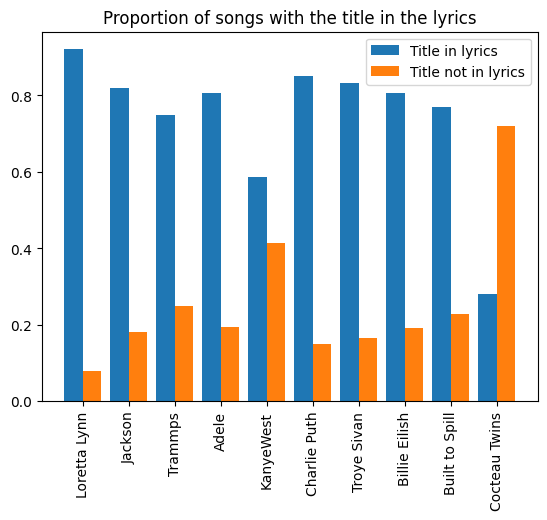

In [290]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [artists[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics')
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics')

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

In [291]:
sub = []
pol = []
for song in raw_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub

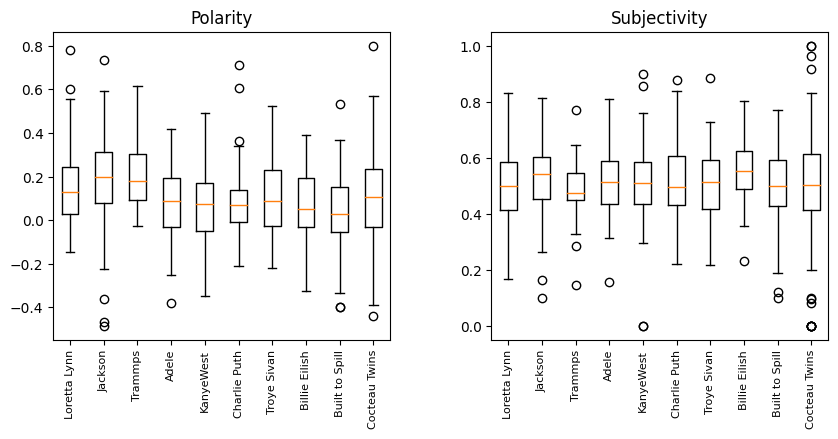

In [292]:
plot_box_graph(["Polarity", "Subjectivity"])

In [293]:
documents = []
for i in range(len(artists)):
    d = df.loc[df['Artist'] == i, 'Lyrics'].tolist()
    d = [word for song in d for word in song]
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : np.arange(len(artists))})

df_docs.head()

,All_Lyrics,Artist
0,i will leav my heart at the door i won't say a...,0
1,i'v got a newfound fangl fandango tango angl a...,1
2,the sooner you give the sooner you get to have...,2
3,i don't know just how it happen i let down my ...,3
4,my mother ha a lot of favorit song that i'v wr...,4


At this point we need to seperate train and test sets.

In [294]:
songs = df["Lyrics"].to_list()
string_songs = [' '.join(s) for s in songs]

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(string_songs)
#stem_count_vector = cv.fit_transform(documents)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(stem_count_vector)

df_word_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_word_weights.sort_values('weight').head()

,word,weight
17194,the,1.060899
17470,to,1.110924
845,and,1.114200
19486,you,1.141007
8869,it,1.238953


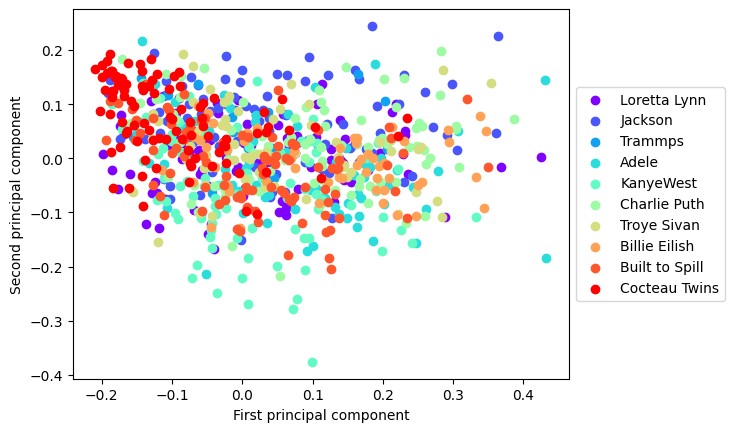

In [295]:
y_filtered = np.array(df["Artist"].to_list())

tfidf_transformer = TfidfTransformer()
tfidf_vector = tfidf_transformer.fit_transform(stem_count_vector).toarray()

pca = PCA(n_components=2).fit(tfidf_vector)
data2D = pca.transform(tfidf_vector)

artist_labels = [artists[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors
for label, art, color in zip(sample, artist_labels, colors):
    mask = (y_filtered == label)
    scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

In [296]:
df_word_weights.sort_values('weight', ascending=False).head()

,word,weight
0,00,8.913338
10732,midil,8.913338
10713,michelin,8.913338
10716,mickala,8.913338
10717,micki,8.913338


In [297]:
tf_idf_vector = tfidf_transformer.transform(stem_count_vector)
tf_idf_matrix = tf_idf_vector.todense()
df_tfidf = pd.DataFrame(tf_idf_matrix, columns=cv.get_feature_names_out())
df_tfidf['Artist'] = df['Artist']
df_tfidf.head()

,00,000,0001,02,03,04,05,06,07,08,...,zsa,zucchini,zuleyka,zuli,zulu,zum,zuptozay,zwei,zzzzzzz,Artist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [298]:
valid_columns = df_tfidf.iloc[:, :-1].select_dtypes(include=np.number)
# Calculate the sum of each row
sum_array = np.array(valid_columns.sum(axis=1))

# Add the sum_array as a new column in the DataFrame
df["TF_IDF_Score"] = sum_array

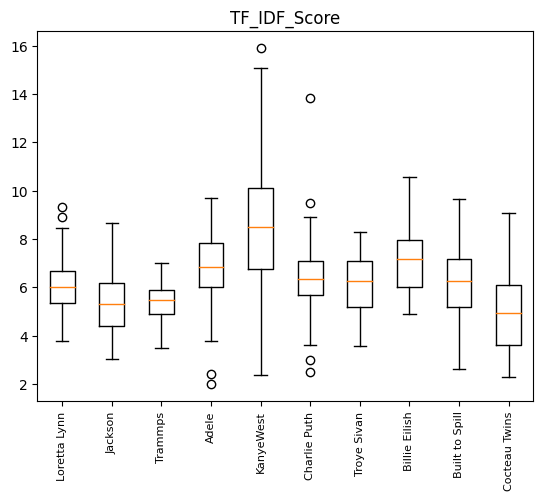

In [299]:
plot_box_graph(["TF_IDF_Score"])

We want a dataframe with the top 500 best words

In [300]:
# Select the columns that satisfy the condition
selected_columns = [column for column in df_tfidf.columns if 3 < df_tfidf[column].astype(bool).sum()]

df_filtered_weights = df_word_weights[df_word_weights["word"].isin(selected_columns)]
df_filtered_weights = df_filtered_weights.sort_values('weight', ascending=False)
df_filtered_weights.head()

,word,weight
7,06,7.997047
4884,displac,7.997047
2392,broker,7.997047
2405,brooklyn,7.997047
4883,dispers,7.997047


In [301]:
# Create a new DataFrame with the selected columns
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in selected_columns], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,06,10,100,1000,11,12,13,15,16,17,...,yuh,yummi,yup,zero,zip,zombi,zone,zoo,zoom,Artist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
old_columns = df_word_weights.shape[0]
new_columns = df_filtered_weights.shape[0]

print(f'Discarded {old_columns - new_columns} words')

Discarded 13518 words


In [303]:
to_keep = df_filtered_weights.iloc[:1000]["word"].tolist()

In [304]:
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in to_keep], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,06,displac,broker,brooklyn,dispers,dismay,serial,disintegr,massiv,mat,...,laundri,dum,larri,droppin,kobe,lalala,lala,lacer,ketchup,dre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


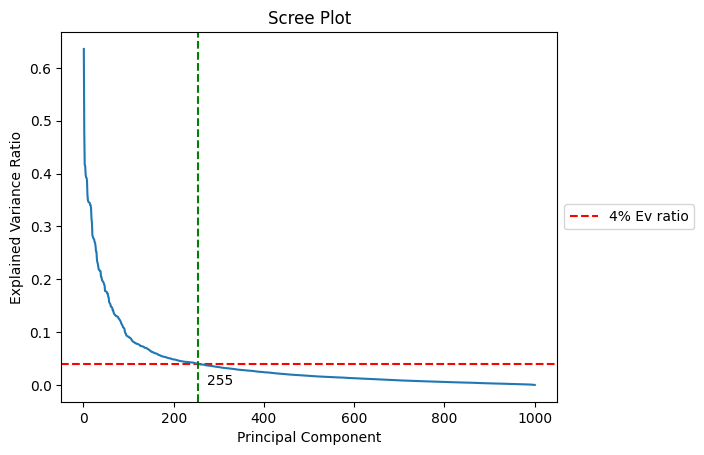

In [305]:
# Perform PCA
pca = PCA()
pca.fit(df_tfidf_reduced)
df_transformed = pca.transform(df_tfidf_reduced)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_*40

plt.axhline(y=0.04, color='r', linestyle='--', label='4% Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='', linestyle='-')

# Find the index of intersection
intersection_index = -1
for i in range(len(explained_variance_ratio)):
    if explained_variance_ratio[i] <= 0.04:
        intersection_index = i
        break

# Add a vertical line at the intersection point
plt.axvline(x=intersection_index + 1, color='g', linestyle='--')
plt.text(intersection_index + 50, 0.0005, f'{intersection_index + 1}', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.show()


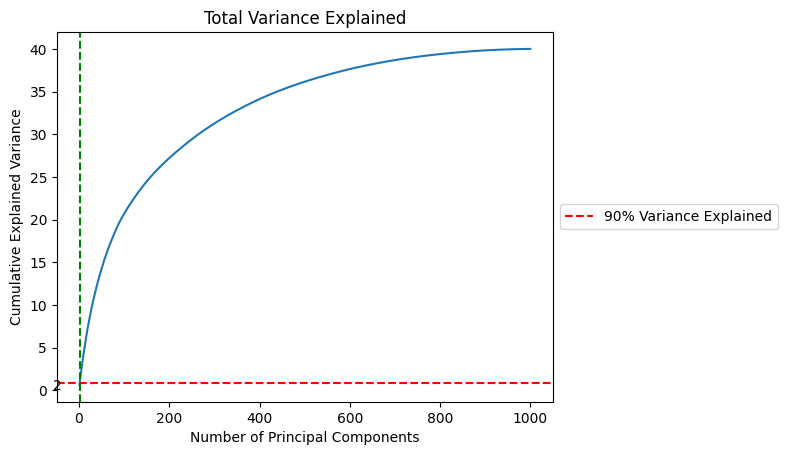

In [306]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 90%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.9)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx - 50, 0.01, f'{idx + 1}', ha='center')

plt.show()

START OF KNN

In [307]:
n_comp = 400
pca = PCA(n_components=n_comp)
df_tfidf_pca = pca.fit_transform(df_tfidf_reduced)

df_filtered_pca = pd.DataFrame(df_tfidf_pca, columns=[f'PC{i}' for i in range(1, n_comp+1)])

df_filtered_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,-0.000414,-0.000288,-0.000187,-0.000273,-0.000175,-0.000199,-0.000237,-0.000258,-0.000174,-0.000171,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
1,-0.000414,-0.000288,-0.000187,-0.000273,-0.000175,-0.000199,-0.000237,-0.000258,-0.000174,-0.000171,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
2,-0.000414,-0.000288,-0.000187,-0.000273,-0.000175,-0.000199,-0.000237,-0.000258,-0.000174,-0.000171,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
3,-0.000422,-0.000296,-0.000192,-0.000282,-0.000180,-0.000205,-0.000244,-0.000267,-0.000181,-0.000177,...,-0.001675,-0.000489,0.003721,0.003822,-0.000028,0.003727,0.003098,-0.001269,-0.002844,0.002313
4,-0.000414,-0.000288,-0.000187,-0.000273,-0.000175,-0.000199,-0.000237,-0.000258,-0.000174,-0.000171,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011


In [308]:
#############
# new data frame containing all the numerical features
############
new_df = pd.concat([df.reset_index(drop=True), df_filtered_pca.reset_index(drop=True)], axis = 1)
new_df = new_df.reset_index(drop=True)
new_df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,"[i, will, leav, my, heart, at, the, door, i, w...",49,286,\nI will leave my heart at the door\nI won't s...,all i ask,0,0.049834,0.029900,0.029900,0.023256,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
1,"[i, know, you'v, got, thing, to, do, i, do, to...",30,168,\nI know you've got things to do (I do too)\nI...,all night parking,0,0.005525,0.005525,0.022099,0.033149,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
2,"[sha, la, la, la, la, la, la, la, sha, la, la,...",47,236,\nSha la la la la la la la\nSha la la la la la...,baby it's you,0,0.003968,0.019841,0.023810,0.011905,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
3,"[wait, do, you, see, my, heart, on, my, sleev,...",52,410,"\nWait, do you see my heart on my sleeve?\nIt'...",best for last,0,0.013514,0.018018,0.027027,0.013514,...,-0.001675,-0.000489,0.003721,0.003822,-0.000028,0.003727,0.003098,-0.001269,-0.002844,0.002313
4,"[if, fish, swam, out, of, the, ocean, and, gre...",59,318,\nIf fish swam out of the ocean\nAnd grew legs...,black & gold,0,0.000000,0.002933,0.032258,0.035191,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011


In [309]:
from sklearn.preprocessing import StandardScaler

numerical_df = new_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
numerical_df.head()

,Nb_Lines,Nb_Words,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_PRIMARY:REGRESSIVE:COGNITION:NARCISSISM,RID_EMOTIONS:ANXIETY,RID_PRIMARY:SENSATION:VISION,...,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400
0,49,286,0.049834,0.029900,0.029900,0.023256,0.016611,0.016611,0.006645,0.006645,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
1,30,168,0.005525,0.005525,0.022099,0.033149,0.016575,0.000000,0.005525,0.005525,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
2,47,236,0.003968,0.019841,0.023810,0.011905,0.000000,0.000000,0.000000,0.000000,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011
3,52,410,0.013514,0.018018,0.027027,0.013514,0.022523,0.000000,0.000000,0.002252,...,-0.001675,-0.000489,0.003721,0.003822,-0.000028,0.003727,0.003098,-0.001269,-0.002844,0.002313
4,59,318,0.000000,0.002933,0.032258,0.035191,0.000000,0.005865,0.008798,0.032258,...,-0.000059,-0.000087,0.000044,-0.000037,-0.000075,-0.000013,-0.000074,0.000081,0.000098,0.000011


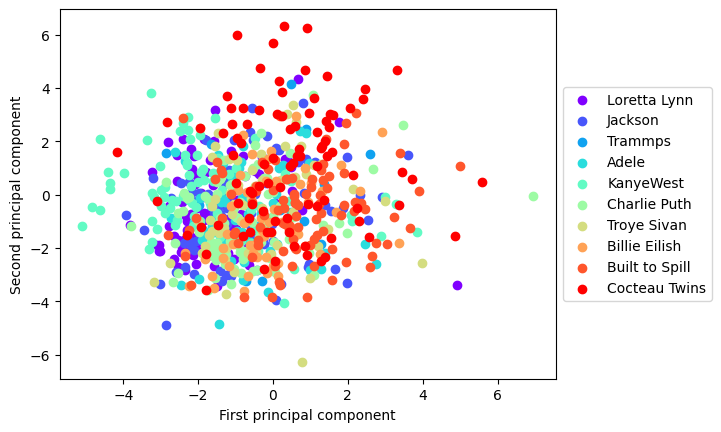

In [310]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

artist_labels = [artists[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors
for label, art, color in zip(sample, artist_labels, colors):
    mask = (y_filtered == label)
    scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

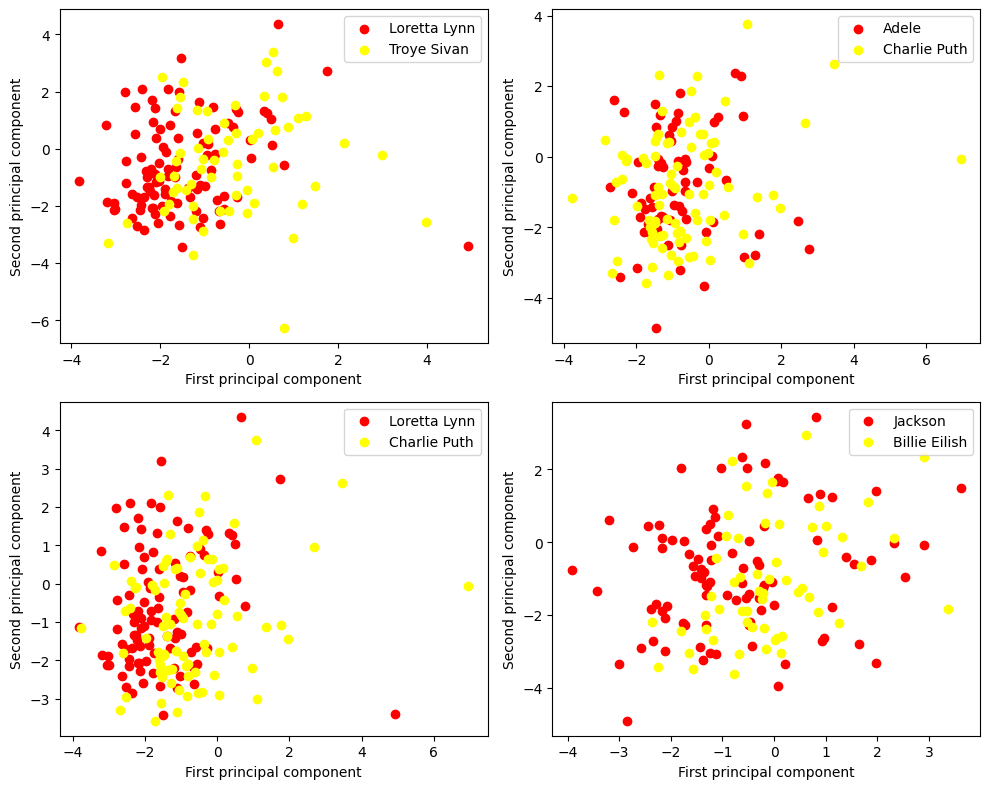

In [311]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

import itertools
import random

# Define the sampled indices and artist labels for each graph
combinations = list(itertools.combinations(sample, 2))
random.shuffle(combinations)
sampled_indices = combinations[:4]
artist_labels_list = [[artists[i] for i in indices] for indices in sampled_indices]

# Assign red and yellow to the first and second labels, respectively
colors_list = ['red', 'yellow']

# Plot the graphs using a loop
plt.figure(figsize=(10, 8))

for i, indices in enumerate(sampled_indices):
    plt.subplot(2, 2, i + 1)
    for j, label in enumerate(indices):
        mask = (y_filtered == label)
        color = colors_list[j % 2]  # Alternate between red and yellow
        scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=color, label=artist_labels_list[i][j])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()

plt.tight_layout()
plt.show()

# GET THE TESTING DATA

In [312]:
train_df, test_df = train_test_split(new_df, test_size= 0.2)

print(f'Training size : {train_df.shape[0]}')
print(f'Testing size : {test_df.shape[0]}')

Training size : 4372
Testing size : 1094


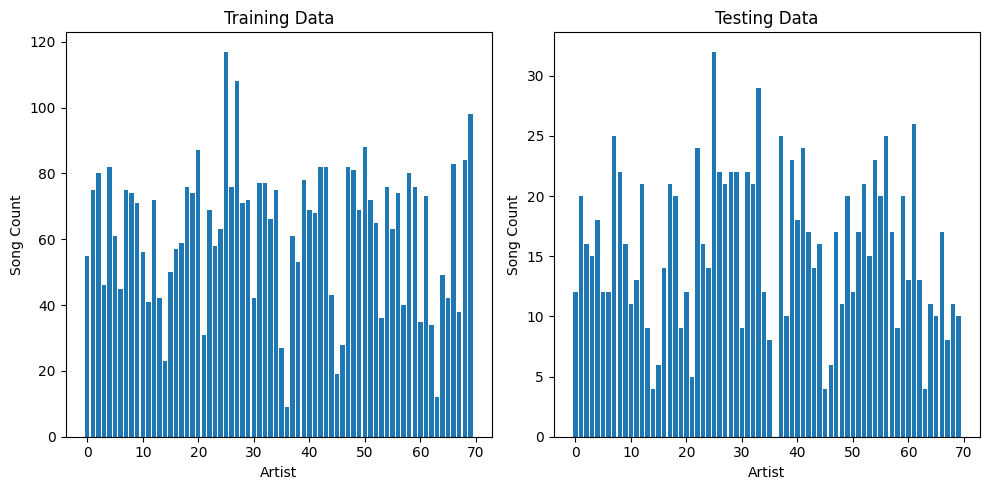

In [313]:
# Get the count of songs per artist in the training dataset
train_artist_counts = train_df['Artist'].value_counts()

# Get the count of songs per artist in the testing dataset
test_artist_counts = test_df['Artist'].value_counts()

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the song distribution per artist in the training dataset
axes[0].bar(train_artist_counts.index, train_artist_counts.values)
axes[0].set_title('Training Data')
axes[0].set_xlabel('Artist')
axes[0].set_ylabel('Song Count')

# Plot the song distribution per artist in the testing dataset
axes[1].bar(test_artist_counts.index, test_artist_counts.values)
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Artist')
axes[1].set_ylabel('Song Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [314]:
scaler = StandardScaler()

x_train = train_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
x_train = scaler.fit_transform(x_train)
y_train = train_df['Artist']

x_test = test_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
x_test = scaler.fit_transform(x_test)
y_test = test_df['Artist'].to_numpy()

# KNN STARTS

In [315]:
def learn_knn(**kwargs):
    
    model = neighbors.KNeighborsClassifier(**kwargs)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    return acc

In [316]:
def run_knn():
    w_accu=[]
    nw_accu=[]
    l1_nw_accu=[]
    l1_w_accu=[]
    max_nei = 50
    big = (0,0,0)

    for i in range(1,max_nei):

        w_accu.append(learn_knn(n_neighbors=i, weights='distance'))
        nw_accu.append(learn_knn(n_neighbors=i))
        l1_w_accu.append(learn_knn(n_neighbors=i, weights='distance', p=1))
        l1_nw_accu.append(learn_knn(n_neighbors=i, p=1))

        if w_accu[-1] > big[0]:
            big = (w_accu[-1], i, 0)

        if nw_accu[-1] > big[0]:
            big = (nw_accu[-1], i, 1)

        if l1_w_accu[-1] > big[0]:
            big = (l1_w_accu[-1], i, 2)

        if l1_nw_accu[-1] > big[0]:
            big = (l1_nw_accu[-1], i, 3)

    best_acc = big[0]
    best_nei = big[1]
    best_param = big[2]

    if best_param == 0:
        best_param = "weighted"
    elif best_param == 1:
        best_param = "not weighted"
    elif best_param == 2:
        best_param = "weighted, L1 distance"
    elif best_param == 3:
        best_param = "not weighted, L1 distance"

    print(f'Best accuracy: {best_acc}\nWith: {best_nei} neighbors, parameters: {best_param}')
    return max_nei, w_accu, nw_accu, l1_w_accu, l1_nw_accu

In [317]:
def plot_knn(max_nei, w_accu, nw_accu, l1_w_accu, l1_nw_accu):
    # Create a list of x-values for the parameter variations (e.g., parameter values from 1 to 30)
    x_values = list(range(1, max_nei))

    # Plot the accuracies
    plt.plot(x_values, nw_accu, marker='', label = 'not weighted')
    plt.plot(x_values, w_accu, marker = '', label = 'weighted')
    plt.plot(x_values, l1_nw_accu, marker='', label = 'not weighted, L1 distance')
    plt.plot(x_values, l1_w_accu, marker = '', label = 'weighted, L1 distance')

    # Add labels and title to the plot
    plt.xlabel('Number of neighbours')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

In [318]:
def test_knn():
    model = neighbors.KNeighborsClassifier(n_neighbors=best_nei, weights= 'distance', p=1)
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, cv=5)
    print("Accuracy scores:", scores)

In [319]:
#y_pred = model.predict(x_test)
#accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
#print(accuracy)

In [320]:
def confusion_matrix(y_test, y_pred):
    
     
    y_test_labels = [artists[y] for y in y_test]
    y_pred_labels = [artists[y] for y in y_pred]
    
    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    
    #index_labels = list(map(lambda artist: 'actual ' + artist, artists))
    index_labels = list(map(lambda artist: artist, artists))

    #column_labels = list(map(lambda artist: 'predicted ' + artist, artists))
    column_labels = list(map(lambda artist: artist, artists))

    df = pd.DataFrame(data=confusion_matrix, index=index_labels, columns=column_labels)
    
    
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
   
    return df


# LOGISTIC REGRESSION STARTS

In [321]:
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_EMOTIONS:AFFECTION,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_SECONDARY:ABSTRACTION,RID_SECONDARY:TEMPORAL:REFERENCES,...,Slang,Rare,FP_Freq,SP_Freq,TP_Freq,SR,Title_In_Song,Polarity,Subjectivity,TF_IDF_Score
0,"[i, will, leav, my, heart, at, the, door, i, w...",49,286,\nI will leave my heart at the door\nI won't s...,all i ask,0,0.049834,0.029900,0.029900,0.023256,...,0.0,0.786713,0.076923,0.017483,0.003497,0.075342,True,-0.069444,0.543827,8.535354
1,"[i, know, you'v, got, thing, to, do, i, do, to...",30,168,\nI know you've got things to do (I do too)\nI...,all night parking,0,0.005525,0.005525,0.022099,0.033149,...,0.0,0.821429,0.059524,0.059524,0.000000,0.056180,False,0.102778,0.517778,8.085017
2,"[sha, la, la, la, la, la, la, la, sha, la, la,...",47,236,\nSha la la la la la la la\nSha la la la la la...,baby it's you,0,0.003968,0.019841,0.023810,0.011905,...,0.0,0.792373,0.033898,0.067797,0.012712,0.031373,True,0.418182,0.472727,1.990149
3,"[wait, do, you, see, my, heart, on, my, sleev,...",52,410,"\nWait, do you see my heart on my sleeve?\nIt'...",best for last,0,0.013514,0.018018,0.027027,0.013514,...,0.0,0.785366,0.029268,0.065854,0.000000,0.027460,True,0.245619,0.462286,8.876300
4,"[if, fish, swam, out, of, the, ocean, and, gre...",59,318,\nIf fish swam out of the ocean\nAnd grew legs...,black & gold,0,0.000000,0.002933,0.032258,0.035191,...,0.0,0.688679,0.040881,0.015723,0.006289,0.040000,False,0.012135,0.377778,6.627149


In [322]:
def n_sets_func(df, nsets):    
    df2 = df.drop(df.columns[[0, 3, 4]], axis=1)
    Pcarray = df_filtered_pca.to_numpy()
    df2.reset_index(drop=True, inplace=True)
    df2['PCA'] = pd.Series(Pcarray.tolist())
    df2 = df2[df2['Artist'] < nsets]
    n_art = nsets
    pos_w = (n_art-1)/n_art
    neg_w = 1/n_art
    fts = df2.columns
    return df2, fts, pos_w, neg_w


In [323]:
def mean_of_arrays(matrix):
    mean_values = np.mean(matrix, axis=0)
    return mean_values.tolist()

In [324]:
def artist_df(artist, df2):
    """
    takes the aritst number and the training dataframe
    returns the mean and std devaition for all somgs of that artist in that dataframe
    """
    art_data = df2[df2['Artist'] == artist]
    arrays = art_data['PCA'].values
    # Convert the arrays into a matrix
    matrix = np.stack(arrays)
    mean = np.array(mean_of_arrays(matrix))
    # Calculate the average features for artist number 4
    average_features_artist = art_data.mean(numeric_only=True)
    # Calculate the standard deviation of features for artist number 4
    std_features_artist = art_data.std(numeric_only=True)
    k= ((pd.DataFrame({'Average': average_features_artist, 'Standard Deviation': std_features_artist})).transpose()).drop("Artist", axis=1)
    return k,mean


In [325]:
def cosine_angle(vector1, vector2):
    """
    Similarity between 2 vectors between 0 and 1. To be used for PCAd TFIDF components.
    """
    dot_prod = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    if(mag1 *mag2 !=0):
        return dot_prod / (mag1 * mag2)
    return 0
    

In [326]:
def std_rows(df):
    """
    Takes a dataframe with the first 2 rows belonging to an artist and the following rows representing songs.
    Returns the dataframe to be trained for that artist.
    """
    art_pca = df.iloc[0, -1]

    for i in range(2, len(df)):
        df.iloc[i, -1] = cosine_angle(art_pca, df.iloc[i, -1])

    first_row = df.iloc[0, :-1]
    s_row = df.iloc[1, :-1]

    mask = s_row != 0  # Create a mask to avoid division by zero
    df.iloc[2:, :-1] = (first_row - df.iloc[2:, :-1]) / np.where(mask, s_row, 1)

    df = df.iloc[2:].reset_index(drop=True)
    return df


In [327]:
#### WIll make the dataframe of songs for any artist
def df_maker(artist, df, df2):
    """ 
    INPUTS
    artist- aritst number, int
    df- dataframe with songs and their features
    output- dataframe with featurs of the song wrt the aritst
    """
    art_df, meanpca = artist_df(artist, df2=df2)
    art_df["PCA"] = [meanpca, None]
    comb_df = pd.concat([art_df, df])
    return (std_rows(comb_df))

In [328]:
def top_K_accs(y_test, arr):
    
    y_test = np.array(y_test)
    l = len(y_test)
    top_accs=[]
    for max_indices in arr:
        s=0
        for i in range(0,l):
            if y_test[i] in max_indices[i]:
                s+=1
        top_accs.append(100*s/l)
    return(top_accs)

In [398]:
def misclassy(y_test, arr):
    misclassified_numbers = Counter()

    for i, true_value in enumerate(y_test):
        if true_value not in arr[i]:
            misclassified_numbers[true_value] += 1

    total_samples = Counter(y_test)  # Count occurrences of each number in y_test

    misclassification_percentages = {
        number: count / total_samples[number] * 100
        for number, count in misclassified_numbers.items()
    }

    top_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1], reverse=True
    )[:5]

    print("The top 5 most misclassified numbers by percentage are:")
    for number, percentage in top_misclassified:
        print(f"Number: {number}, Misclassification percentage: {percentage:.2f}%")



In [461]:
def logistic(n_art, df, top):
    df2, _, pos_w, neg_w = n_sets_func(df=df, nsets =n_art)
    y = df2['Artist']
    X = df2.drop('Artist', axis=1)
    fts = X.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    probs =[]
    coeffs=[]
    for i in range(0,n_art):
        X2 = df_maker(artist = i,df = X_train, df2 = df2)
        X2 = pd.concat([X2.reset_index(drop=True), X_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = pd.concat([df_maker(artist =i,df = X_test, df2=df2).reset_index(drop=True), X_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = y_train.apply(lambda x: 1 if x == i else 0)
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        coefficients = logreg.coef_
        coeffs.append(coefficients[0])
        probs.append(logreg.predict_proba(X3)[:, 1])
    coeffs = np.vstack(coeffs)
    coeffs= np.mean(coeffs, axis=0)
    probs = np.array(probs)
    arr=[]
    for i in top:
        arr.append((np.argsort(probs, axis=0)[-i:, :]).transpose())
    print()
    # arr contains raw predictions of top k in a list
    # brr contains the accuracies
    # crr contains the coefficients each time
    return arr, top_K_accs(y_test=y_test, arr=arr), coeffs, y_test, fts

In [451]:
# Plot each array of y values
def plot_top_tog(brr, nlist, top):
    brr2 = brr

    max_len = max(len(sublist) for sublist in brr2)
    drr = [[] for _ in range(max_len)]

    for sublist in brr2:
        for i, element in enumerate(sublist):
            drr[i].append(element)

    brr2=drr

    counter=0
    for y_values in brr2:
        plt.plot(nlist[-len(y_values):], y_values, marker='o', label = "top "+str(top[counter])+" choices")
        counter+=1

    # Add labels and title
    plt.xlabel('Number of aritsts')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of n artists with top k choices')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()

In [365]:
def process_data(data, st, name):
    features = data['feature']
    coefficients = data[name]
    
    new_features = []
    new_coefficients = []
    pos_coefficients = []
    pos_total = 0.0
    
    for feature, coefficient in zip(features, coefficients):
        if feature.startswith(st):
            pos_coefficients.append(coefficient)
        else:
            new_features.append(feature)
            new_coefficients.append(coefficient)
    
    if pos_coefficients:
        pos_total = sum(pos_coefficients)
        new_features.append(st+' total')
        new_coefficients.append(pos_total)
    
    processed_data = {
        'feature': new_features,
        name: new_coefficients
    }
    
    return processed_data

In [370]:
def plotter(data, name):
    feature_importance_df = pd.DataFrame(data)
    fig = px.bar(feature_importance_df.sort_values(name), x='feature', y=name)
    fig.show()

In [458]:
def feature_imp(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
        for i in range(0,len(fts2)):
            if(fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        data = {'feature': fts2, 'coefficient': coeffs}
        plotter(data, 'coefficient')
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2/np.linalg.norm(coeffs2)
        data = {'feature': fts2, 'coefficient': coeffs2}
        for bruh in fts3:
            data = process_data(data, bruh[:3], 'coefficient')
        plotter(data, 'coefficient')
        coeffs3 = 100*coeffs2/np.sum(coeffs2)
        data = {'feature': fts2, 'Percentage': coeffs3}
        for bruh in fts3:
            data = process_data(data, bruh[0:3], 'Percentage')
        plotter(data, 'Percentage')



The top 5 most misclassified numbers by percentage are:
Number: 0, Misclassification percentage: 46.67%
Number: 9, Misclassification percentage: 36.36%
Number: 2, Misclassification percentage: 23.53%
Number: 6, Misclassification percentage: 23.08%
Number: 3, Misclassification percentage: 20.00%

The top 5 most misclassified numbers by percentage are:
Number: 6, Misclassification percentage: 60.00%
Number: 10, Misclassification percentage: 52.63%
Number: 11, Misclassification percentage: 50.00%
Number: 9, Misclassification percentage: 38.89%
Number: 8, Misclassification percentage: 38.89%


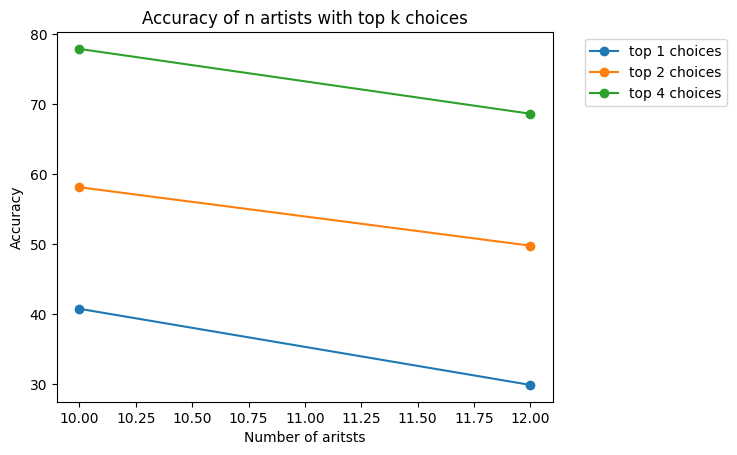

In [462]:
nlist=[10,12]
arr=[]
brr=[]
crr=[]
yrr=[]
top=[]
fts = np.array(df.columns)
for n in nlist:
    top =[2**i for i in range(0, (int)(np.log2(n//2)+1))]
    ar,br,cr,y_test,fts = logistic(n_art=n,df =df, top = top)
    arr.append(ar)
    brr.append(br)
    crr.append(cr)
    yrr.append(y_test)
    misclassy(y_test=y_test, arr = ar[-1])
plot_top_tog(brr = brr, nlist = nlist, top = top)
feature_imp(crr=crr, fts = fts)

